### Set up environment

In [ ]:
import os

import lateral_signaling as lsig
import numpy as np
import pandas as pd
from tqdm import tqdm
import numba

import scipy.stats as st
from scipy.spatial import Voronoi
from scipy.sparse import csr_matrix

import holoviews as hv
import colorcet as cc
hv.extension("matplotlib")

import matplotlib.pyplot as plt
%matplotlib inline

import bebi103
# import bokeh_catplot
import iqplot
import bokeh.io
bokeh.io.output_notebook()

In [ ]:
%load_ext blackcellmagic

<hr>

### Metrics for activation behavior

In [3]:
@numba.njit
def is_monotonic(arr):
    return not np.any(np.diff(arr) < 0)

In [4]:
@numba.njit
def is_biphasic(arr, pct_thresh):
    return (np.diff(arr > pct_thresh) != 0).sum() > 1

In [5]:
@numba.njit
def is_propagated(arr, pct_thresh):
    return np.any(arr > pct_thresh)

### Functions to approximate critical values of phase boundary

In [6]:
@numba.njit
def rho_crit_approx(g, a=3.1, b=4.1):
    return a - b * np.log10(g)

In [7]:
@numba.njit
def t_crit_approx(g, rho_0, rho_max, *rho_crit_args):
    rho_crit = rho_crit_approx(g, *rho_crit_args)
    return -1/g * np.log((rho_max - rho_crit) / rho_crit * rho_0 / (rho_max - rho_0) )

In [8]:
@numba.njit
def t_crit_approx_levelset(t_crit, g, rho_max, *rho_crit_args):
    rho_crit = rho_crit_approx(g, *rho_crit_args)
    return rho_max * rho_crit / (rho_crit + (rho_max - rho_crit) * np.exp(g * t_crit))

## Read in data from HPC runs

In [9]:
from glob import glob
import os

In [14]:
data_dir = "sim_data"

save_dir  = "C://Users/Pranav/git/evomorph/lateral_signaling/plots/"

save_figs = False
fig_fmt   = "png"
dpi       = 180

<hr>

# Load data from parameter sweep

In [39]:
trial_dir, trial_name = "C://Users/Pranav/git/evomorph/lateral_signaling", "lowcis_expbeta"
run_name = "20210426_sweep_TCphase_dense_ling_nodilution"

__Load parameter set from file__

In [41]:
# Search trial_dir for parameter set CSV
params_regexp = "*" + trial_name + "*.csv"
params_path = glob(os.path.join(trial_dir, params_regexp))

# Load parameter set
if len(params_path) == 0:
    raise FileNotFoundError(
        f"No file matches the regular expression `{params_regexp}` "
        + f"in the directory `{os.path.abspath(trial_dir)}` ."
    )
elif len(params_path) > 1:
    raise FileNotFoundError(
        f"More than one file matches the regular expression "
        + f"`{params_regexp}` in the directory "
        + f"`{os.path.abspath(trial_dir)}` "
    )
else:
    # Read trial parameters
    params_path = os.path.abspath(params_path[0])
    params_df = pd.read_csv(params_path)

# Get arguments for beta function
is_beta_arg = [p.startswith("beta_") for p in params_df["parameter"].values]
beta_args   = params_df.value.values[is_beta_arg]

# Get the delay parameter
is_delay    = [p == "delay" for p in params_df["parameter"].values]
delay       = params_df.value.values[is_delay][0]

# Package all other parameters 
is_param    = [not (ba or d) for ba, d in zip(is_beta_arg, is_delay)]
param_names = params_df.parameter.values[is_param].astype(str)
param_vals  = params_df.value.values[is_param].astype(np.float32)

# Package arguments for lsig.integrate_DDE and 
#   lsig.integrate_DDE_varargs. Density param is 
#   initialized with an arbitrary value.
dde_args = *param_vals, 1.

# Get `g`
where_g = next(i for i, pn in enumerate(param_names) if "g" == pn)
g = param_vals[where_g]

# (Optional) Remove `g` from signaling parameters
dde_args = [*dde_args[:where_g], *dde_args[(where_g+1):]]

# Get index of `rho` (last argument)
where_rho = len(dde_args) - 1

# Get `k`
where_k = next(i for i, pn in enumerate(param_names) if "k" == pn)
k = param_vals[where_k]
thresh = k

__Load data from file__

In [42]:
data_regexp = os.path.join(data_dir, run_name, "*_results.npz")
data_path = [os.path.abspath(f) for f in glob(data_regexp)]

# Check for one matching run in data_dir
assert len(data_path) != 0, "Could not find data with regexp {}".format(os.path.abspath(data_regexp))
assert len(data_path) == 1, "More than one file matching regexp {}:\n{}".format(os.path.abspath(data_regexp), data_path)

In [43]:
# Read data
data_file = data_path[0]
npz = np.load(data_file)

# Unpack variables
n = npz["n"]
t = npz["t"]
random_seeds = npz["random_seeds"]
sender_idx_rep = npz["sender_idx_rep"]
param_names = npz["param_names"]
param_space = npz["param_space"]
# S_actnum_param_constant = npz["S_actnum_param_constant"]
# S_tcmean_param_constant = npz["S_tcmean_param_constant"]
S_actnum_param = npz["S_actnum_param"]
S_tcmean_param = npz["S_tcmean_param"]

# Get parmaeter sampling values
rep_space     = np.sort(np.unique(param_space[:, 0].astype(int)))
g_space       = np.sort(np.unique(param_space[:, 1]))
rho_0_space   = np.sort(np.unique(param_space[:, 2]))
rho_max_space = np.sort(np.unique(param_space[:, 3]))

# Get number of runs sampled
n_runs = param_space.shape[0]
n_reps = rep_space.size
n_sets = n_runs // n_reps

# Store run metadata in DataFrame object
S_prop_df = pd.DataFrame(param_space, columns=param_names)
S_prop_df = S_prop_df.reset_index()
S_prop_df.rep = S_prop_df.rep.astype(int)

# Group runs by replicate
S_prop_rep_grp = S_prop_df.groupby(list(param_names[1:]))["index"]
S_prop_rep_grp = list(S_prop_rep_grp)

# Get sample numbers of each replicate set
S_prop_rep_idx = np.empty((n_sets, n_reps), dtype=int)
for i in range(n_runs // n_reps):
    S_prop_rep_idx[i] = S_prop_rep_grp[i][1].values

# Get parameters in each replicate set, preserving order 
param_space_agg = param_space[S_prop_rep_idx[:, 0], 1:]

In [44]:
print("Unpacked variables:", *list(npz.keys()), sep="\n\t")
print()
print(
    "Number of runs:",
    "{0} ({1} sets of {2} replicates)".format(n_runs, n_sets, n_reps),
    sep="\n\t",
)
print()
print("Parameters scanned:")
print(*["\t" + pn for pn in param_names])

Unpacked variables:
	n
	t
	random_seeds
	sender_idx_rep
	param_names
	param_space
	S_actnum_param
	S_tcmean_param

Number of runs:
	72000 (14400 sets of 5 replicates)

Parameters scanned:
	rep 	g 	rho_0 	rho_max


In [32]:
# Number of activated cells (mean of n = n_reps)
S_actnum_mean = S_actnum_param[S_prop_rep_idx, :].mean(axis=1)

# Mean fluorescence (mean of n = n_reps)
S_tcmean_mean = S_tcmean_param[S_prop_rep_idx, :].mean(axis=1)

# % of cells activated
S_prop_param = S_actnum_param / n
S_prop_mean = S_actnum_mean / n

:Scatter   [x]   (y)
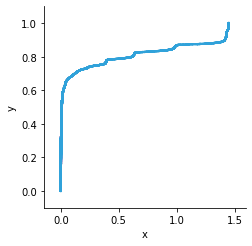

In [34]:
# ECDF of mean fluorescence at end of simulation time
p = lsig.ecdf(S_tcmean_mean[:, -1])
p.opts(s=5)

In [48]:
# Calculate initial increase in signal
dS_dt_init_mean = (S_tcmean_mean[:, 1] - S_tcmean_mean[:, 0]) / (t[1] - t[0])

# step_delay = int(delay / (t[1] - t[0]))
# dS_dt_init_mean = (S_tcmean_mean[:, step_delay + 1] - S_tcmean_mean[:, step_delay]) / (t[1] - t[0])


:Scatter   [x]   (y)
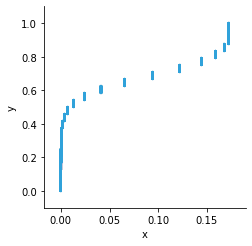

In [49]:
p = lsig.ecdf(dS_dt_init_mean)
p.opts(s=5)

In [64]:
# Threshold to decide whether lattice is activated
end_thresh = 0.05 

# THreshold to decide whether lattice is initially activated
init_thresh = 0.05

In [65]:
activates = (dS_dt_init_mean > init_thresh).astype(int)
stays_active = (S_tcmean_mean[:, -1] > end_thresh).astype(int)

In [66]:
phase = 2 - activates - activates * stays_active

<hr>

### Plot 2D phase boundary for constant density

:Points   [x,y]
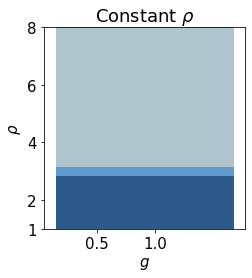

In [67]:
mask = param_space_agg[:, 1] == param_space_agg[:, 2]

constant_dens_plot = hv.Points(
    (lsig.g_to_units(param_space_agg[mask, 0]), param_space_agg[mask, 2])
).opts(
    title = r"Constant $\rho$",
#     xlim = (-1, 1),
    ylim = ( 1, 8),
    xlabel = r"$g$",
    xticks = (-1., -0.5, 0., 0.5, 1),
    ylabel = r"$\rho$",
    yticks = (1, 2, 4, 6, 8),
    marker = "s",
    s=100,
    c=np.array(lsig.cols_blue)[phase[mask]], 
    cmap="plasma",
#     logx=True, 
    fontscale=1.5,
)

constant_dens_plot

In [71]:
param_space_agg[np.logical_and(phase == 1, mask)]

array([[0.25      , 3.        , 3.        ],
       [0.33333333, 3.        , 3.        ],
       [0.41666667, 3.        , 3.        ],
       [0.5       , 3.        , 3.        ],
       [0.58333333, 3.        , 3.        ],
       [0.66666667, 3.        , 3.        ],
       [0.75      , 3.        , 3.        ],
       [0.83333333, 3.        , 3.        ],
       [0.91666667, 3.        , 3.        ],
       [1.        , 3.        , 3.        ],
       [1.08333333, 3.        , 3.        ],
       [1.16666667, 3.        , 3.        ],
       [1.25      , 3.        , 3.        ],
       [1.33333333, 3.        , 3.        ],
       [1.41666667, 3.        , 3.        ],
       [1.5       , 3.        , 3.        ],
       [1.58333333, 3.        , 3.        ],
       [1.66666667, 3.        , 3.        ],
       [1.75      , 3.        , 3.        ],
       [1.83333333, 3.        , 3.        ],
       [1.91666667, 3.        , 3.        ],
       [2.        , 3.        , 3.        ],
       [2.

In [68]:
g_plot_ = np.linspace(-1, 1, 100)

approx_bound = rho_crit_approx(10 ** g_plot_)

:Layout
   .Points.I  :Points   [x,y]
   .Overlay.I :Overlay
      .Points.I :Points   [x,y]
      .Curve.I  :Curve   [x]   (y)
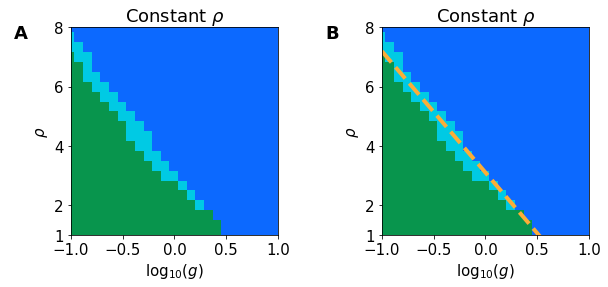

In [176]:
fit_curve = hv.Curve(
    (g_plot_, approx_bound)
).opts(
    c=cc.CET_L8[200],
    linewidth=4,
    linestyle="dashed",
)

constant_dens_plot + (constant_dens_plot * fit_curve) # + (constant_dens_plot2 * fit_curve)

## Plot phase diagram with `t_crit` level sets

In [177]:
param_space_3d = param_space_agg.copy()
param_space_3d[:, 0] = np.log10(param_space_3d[:, 0])
# param_space_3d[:, 2] = param_space_3d[:, 2] - param_space_3d[:, 1]
which_growing = param_space_3d[:, 2] >= param_space_3d[:, 1]

In [178]:
phase_clrs = np.array([*cc.glasbey_warm])[phase_behavior_new]

In [179]:
# t_crit = 5
# rho_max_ls = np.linspace(1, 8, 50)
# log10g_ls = np.linspace(-1, 0.75, 50)

# X, Y = np.meshgrid(log10g_ls, rho_max_ls)
# rho_crit_ls = rho_crit_approx(10**X)
# Z = t_crit_approx_levelset(t_crit, 10**X, Y)

# tol = 1e-5
# valid_samples = np.logical_and(Y - rho_crit_ls >= -tol, rho_crit_ls - Z >= -tol)

# xx, yy, zz = X[valid_samples], Y[valid_samples], Z[valid_samples]

In [180]:
t_crits = [1, 10]
n_samples = 50
tol = 1e-5

In [181]:
def plot_3d_phase_boundaries_log10(t_crits, n_samples, tol=1e-5, dpi=150, azim=300, elev=20):

    rho_max_ls = np.linspace(1, 8, n_samples)
    log10g_ls = np.linspace(-1, 1, n_samples)

    X, Y = np.meshgrid(log10g_ls, rho_max_ls)
    rho_crit_ls = rho_crit_approx(10 ** X)

    rho_crit_ls = t_crit_approx_levelset(0, 10 ** X, Y)
    valid_samples = Y - rho_crit_ls >= -tol
    xx, yy = X[valid_samples].flatten(), Y[valid_samples].flatten()

    fig = plt.figure(figsize=(4, 4))
    ax = plt.axes(projection="3d", )
    ax.azim = azim
    ax.elev = elev

    # ax.contour3D(X, Y, Z, 50, cmap='binary')
    ax.set_xlabel(r"$log_{10}(g)$")
    ax.set_xticks([-1., -0.5, 0., 0.5, 1.])
    ax.set_xticklabels([r"$-1$", r"$-0.5$", r"$0$", r"$0.5$", r"$1$"])
    ax.set_ylabel(r"$\rho_{max}$")
    ax.set_yticks([0, 2, 4, 6, 8])
    ax.set_ylim3d([0, 8])
    ax.set_zlabel(r"$\rho_0$")
    ax.set_zticks([0, 2, 4, 6, 8])
    ax.set_zlim3d([0, 8])
    ax.scatter(
        *param_space_3d[which_growing].T[np.array([0, 2, 1])],
        c=phase_clrs[which_growing],
        s=170,
        marker="s",
        alpha=0.005,
        linewidth=0,
    )
    ax.set_title(r"$t_{crit} =$ " + ", ".join([str(i) for i in t_crits]))

    for i, tc in enumerate(t_crits):

        zz = t_crit_approx_levelset(tc, 10 ** xx, yy)
        ax.plot_trisurf(
            xx.flatten(),
            yy.flatten(),
            zz.flatten(),
            facecolor=cc.glasbey_cool[i],
            alpha=0.5,
            edgecolor="none",
        )

    # ax.scatter(xx, yy, zz, c=cc.bmy[0], s=1, alpha=0.5)

#     plt.tight_layout()
    fig.set_facecolor("w")
    ax.set_facecolor("w")
    plt.gcf().set(dpi=dpi)

    return fig, ax

plots\20210407_sweep_TCphase_dense_3d_phase_tcrit_0_nsamples_50


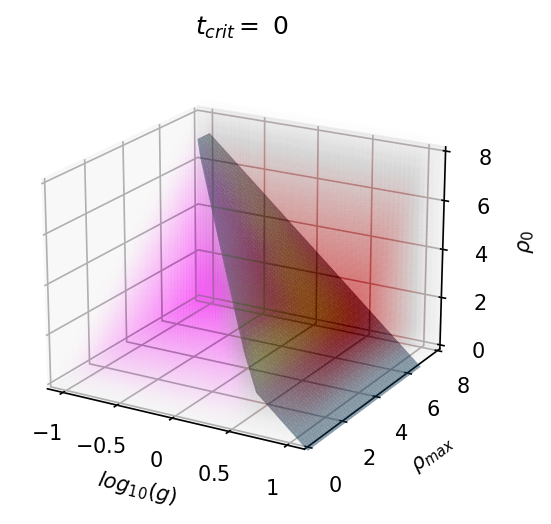

In [182]:
t_crits = [0]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_log10(t_crits, n_samples)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

plots\20210407_sweep_TCphase_dense_3d_phase_tcrit_1_nsamples_50


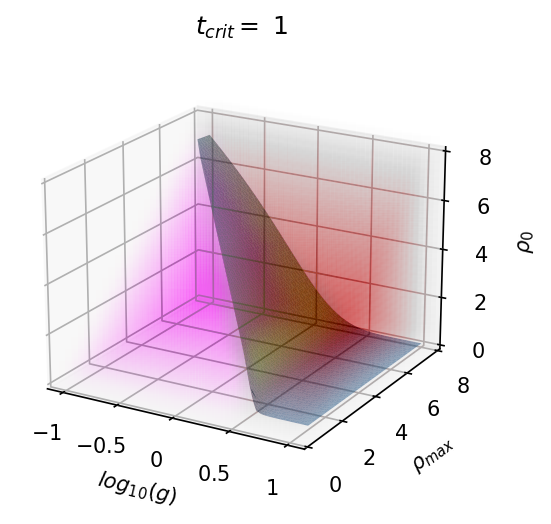

In [183]:
t_crits = [1]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_log10(t_crits, n_samples)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

plots\20210407_sweep_TCphase_dense_3d_phase_tcrit_5_nsamples_50


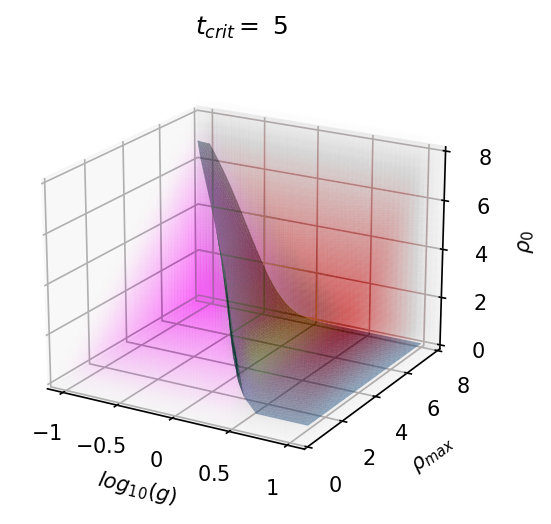

In [184]:
t_crits = [5]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_log10(t_crits, n_samples)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

plots\20210407_sweep_TCphase_dense_3d_phase_tcrit_1_10_nsamples_50


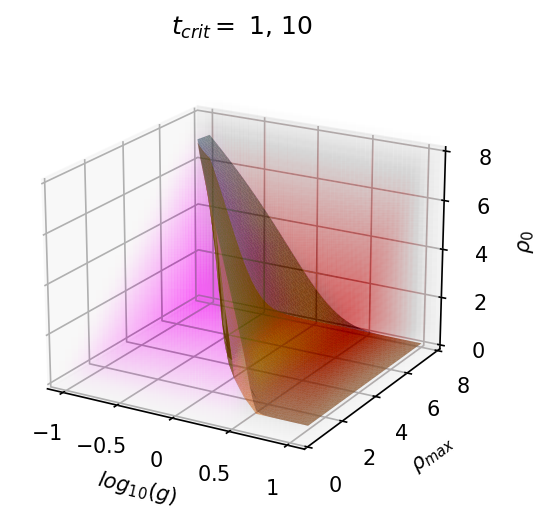

In [185]:
t_crits = [1, 10]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_log10(t_crits, n_samples)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

plots\20210407_sweep_TCphase_dense_3d_phase_tcrit_0_20_nsamples_50


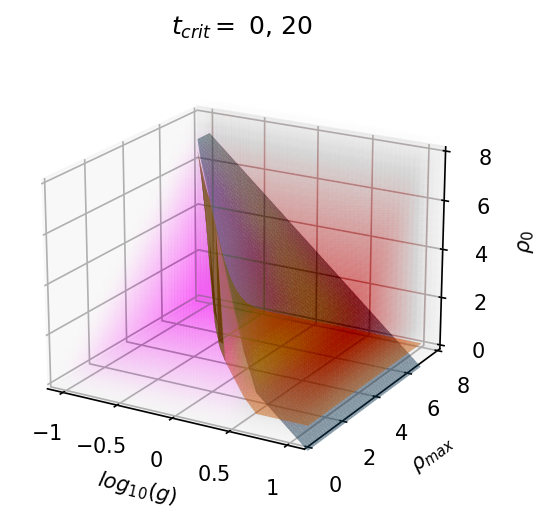

In [186]:
t_crits = [0, 20]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_log10(t_crits, n_samples)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

plots\20210407_sweep_TCphase_dense_3d_phase_tcrit_0_5_nsamples_50


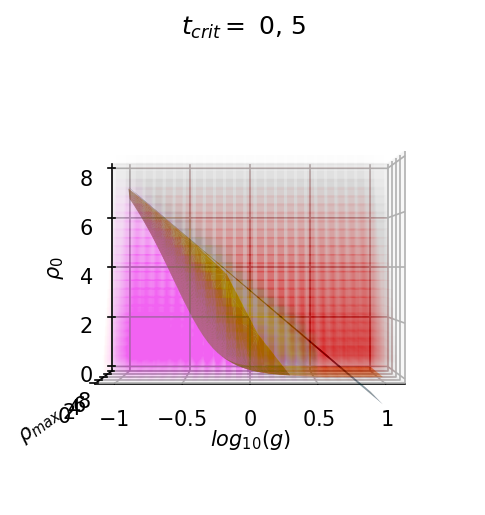

In [187]:
t_crits = [0, 5]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_log10(t_crits, n_samples, azim=270, elev=0)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

<hr>

<hr>

In [24]:
# # Threshold for phase behavior
# phase_thresh = 0.05   #  % activated cells

# # n_runs = S_prop_param.shape[0]

# # Calculate phase behavior
# iterator = range(n_runs)
# # iterator = tqdm(iterator)
# S_prop_bool = np.zeros((n_runs,), dtype=bool)
# S_biph_bool = np.zeros((n_runs,), dtype=bool)

# for i in iterator:
#     S_prop_bool[i] = is_propagated(S_prop_param[i], phase_thresh)
#     S_biph_bool[i] = is_biphasic(S_prop_param[i], phase_thresh)
# #     monotonicity = np.array([is_monotonic(s) for s in S_prop_param])

In [35]:
# # Average phase behavior over replicates
# S_prop_pct = S_prop_bool[S_prop_rep_idx].mean(axis=1)
# S_biph_pct = S_biph_bool[S_prop_rep_idx].mean(axis=1)

# # If any replicates show behavior, set True
# S_prop_bool_agg = np.any(S_prop_bool[S_prop_rep_idx], axis=1)
# S_biph_bool_agg = np.any(S_biph_bool[S_prop_rep_idx], axis=1)

# # Convert to phase
# #   0 = no propagation, 1 = propagation, 2 = biphasic
# phase_behavior = (1 + S_biph_bool_agg) * S_prop_bool_agg

C:\Users\Pranav\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


__Visualize distribution of mean TC fluorescence at end of sampling time__

In [43]:
bokeh.io.output_notebook()

Loading BokehJS ...

In [44]:
p = iqplot.ecdf(S_tcmean_mean[:, -1], q="mean fluorescence (AU)", title="ecdf")
# p = bokeh_catplot.ecdf()

bokeh.io.show(p)


In [31]:
dS_dt_init_mean = (S_tcmean_mean[:, 1] - S_tcmean_mean[:, 0]) / (t[1] - t[0])

In [169]:
p = bokeh_catplot.ecdf(dS_dt_init_mean)

bokeh.io.show(p)

In [170]:
init_thresh = 0.05
init_behavior = (dS_dt_init_mean > init_thresh).astype(int)
end_behavior = (S_tcmean_mean[:, -1] > phase_thresh).astype(int)

In [171]:
# dS_dt_init_mean[np.logical_and(end_behavior.astype(bool), which_growing)].min()

In [172]:
# param_space_agg[np.logical_and((init_behavior - end_behavior) < 0, which_growing)]

In [173]:
phase_behavior_new = end_behavior + 2 * (1 - end_behavior) * init_behavior

# Log-2 sampled `g`

In [188]:
# run_name = "20210407_sweep_TCphase_dense"
run_name = "20210415_sweep_TCphase_dense_log2g"

In [189]:
data_regexp = os.path.join(data_dir, run_name, "*_results.npz")
data_path = [os.path.abspath(f) for f in glob(data_regexp)]

if len(data_path) == 0:
    print("Could not find data with regexp {}".format(os.path.abspath(data_regexp)))
elif len(data_path) > 1:
    print("More than one file matching regexp {}".format(os.path.abspath(data_regexp)))
    print("Matching files:")
    print(data_path)

In [190]:
# Read data
data_file = data_path[0]
npz = np.load(data_file)

# Unpack variables
n = npz["n"]
t = npz["t"]
random_seeds = npz["random_seeds"]
sender_idx_rep = npz["sender_idx_rep"]
param_names = npz["param_names"]
param_space = npz["param_space"]
# S_actnum_param_constant = npz["S_actnum_param_constant"]
# S_tcmean_param_constant = npz["S_tcmean_param_constant"]
S_actnum_param = npz["S_actnum_param"]
S_tcmean_param = npz["S_tcmean_param"]

# Get parmaeter sampling values
rep_space     = np.sort(np.unique(param_space[:, 0].astype(int)))
g_space       = np.sort(np.unique(param_space[:, 1]))
rho_0_space   = np.sort(np.unique(param_space[:, 2]))
rho_max_space = np.sort(np.unique(param_space[:, 3]))

# Get number of runs sampled
n_runs = param_space.shape[0]
n_reps = rep_space.size
n_sets = n_runs // n_reps

# Store run metadata in DataFrame object
S_prop_df = pd.DataFrame(param_space, columns=param_names)
S_prop_df = S_prop_df.reset_index()
S_prop_df.rep = S_prop_df.rep.astype(int)

# Group runs by replicate
S_prop_rep_grp = S_prop_df.groupby(list(param_names[1:]))["index"]
S_prop_rep_grp = list(S_prop_rep_grp)

# Get sample numbers of each replicate set
S_prop_rep_idx = np.empty((n_sets, n_reps), dtype=int)
for i in range(n_runs // n_reps):
    S_prop_rep_idx[i] = S_prop_rep_grp[i][1].values

# Get parameters in each replicate set, preserving order 
param_space_agg = param_space[S_prop_rep_idx[:, 0], 1:]

In [191]:
print("Unpacked variables:", *list(npz.keys()), sep="\n\t")
print()
print(
    "Number of runs:",
    "{0} ({1} sets of {2} replicates)".format(n_runs, n_sets, n_reps),
    sep="\n\t",
)
print()
print("Parameters scanned:")
print(*["\t" + pn for pn in param_names])

Unpacked variables:
	n
	t
	random_seeds
	sender_idx_rep
	param_names
	param_space
	S_actnum_param
	S_tcmean_param

Number of runs:
	72000 (14400 sets of 5 replicates)

Parameters scanned:
	rep 	g 	rho_0 	rho_max


In [192]:
# Number of activated cells (mean of n = n_reps)
S_actnum_mean = S_actnum_param[S_prop_rep_idx, :].mean(axis=1)

# Mean fluorescence (mean of n = n_reps)
S_tcmean_mean = S_tcmean_param[S_prop_rep_idx, :].mean(axis=1)

# % of cells activated
S_prop_param = S_actnum_param / n
S_prop_mean = S_actnum_mean / n

In [193]:
# Threshold for phase behavior
phase_thresh = 0.05   #  % activated cells

# n_runs = S_prop_param.shape[0]

# Calculate phase behavior
iterator = range(n_runs)
# iterator = tqdm(iterator)
S_prop_bool = np.zeros((n_runs,), dtype=bool)
S_biph_bool = np.zeros((n_runs,), dtype=bool)

for i in iterator:
    S_prop_bool[i] = is_propagated(S_prop_param[i], phase_thresh)
    S_biph_bool[i] = is_biphasic(S_prop_param[i], phase_thresh)
#     monotonicity = np.array([is_monotonic(s) for s in S_prop_param])

In [194]:
# Average phase behavior over replicates
S_prop_pct = S_prop_bool[S_prop_rep_idx].mean(axis=1)
S_biph_pct = S_biph_bool[S_prop_rep_idx].mean(axis=1)

# If any replicates show behavior, set True
S_prop_bool_agg = np.any(S_prop_bool[S_prop_rep_idx], axis=1)
S_biph_bool_agg = np.any(S_biph_bool[S_prop_rep_idx], axis=1)

# Convert to phase
#   0 = no propagation, 1 = propagation, 2 = biphasic
phase_behavior = (1 + S_biph_bool_agg) * S_prop_bool_agg

__Visualize distribution of mean TC fluorescence at end of sampling time__

In [195]:
p = bokeh_catplot.ecdf(S_tcmean_mean[:, -1])

bokeh.io.show(p)

In [196]:
# dS_dt_init_mean = (S_tcmean_mean[:, 1] - S_tcmean_mean[:, 0]) / (t[1] - t[0])

In [197]:
p = bokeh_catplot.ecdf(dS_dt_init_mean)

bokeh.io.show(p)

In [198]:
# dS_dt_init_mean[np.logical_and(end_behavior.astype(bool), which_growing)].min()

In [199]:
init_thresh = 0.05
init_behavior = (dS_dt_init_mean > init_thresh).astype(int)
end_behavior = (S_tcmean_mean[:, -1] > phase_thresh).astype(int)

In [200]:
param_space_agg[np.logical_and((init_behavior - end_behavior) < 0, which_growing)]

array([[1.58740105, 2.        , 2.        ],
       [1.78179744, 1.33333333, 1.33333333],
       [1.78179744, 1.33333333, 1.66666667],
       [1.78179744, 1.33333333, 2.        ],
       [1.78179744, 1.66666667, 1.66666667],
       [2.        , 0.33333333, 0.33333333],
       [2.        , 0.33333333, 0.66666667],
       [2.        , 0.33333333, 1.        ],
       [2.        , 0.33333333, 1.33333333],
       [2.        , 0.33333333, 1.66666667],
       [2.        , 0.33333333, 2.        ],
       [2.        , 0.66666667, 0.66666667],
       [2.        , 0.66666667, 1.        ],
       [2.        , 0.66666667, 1.33333333],
       [2.        , 0.66666667, 1.66666667],
       [2.        , 1.        , 1.        ],
       [2.        , 1.        , 1.33333333],
       [2.        , 1.        , 1.66666667],
       [2.        , 1.33333333, 1.33333333],
       [2.        , 1.33333333, 1.66666667],
       [2.        , 1.66666667, 1.66666667],
       [2.2449241 , 0.33333333, 0.33333333],
       [2.

In [201]:
phase_behavior_new = end_behavior + 2 * (1 - end_behavior) * init_behavior

### Plot 2D phase boundary for constant density

:Points   [x,y]
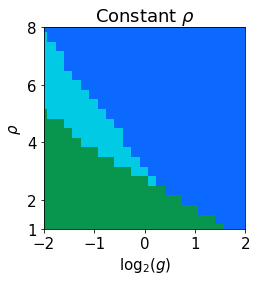

In [202]:
mask = param_space_agg[:, 1] == param_space_agg[:, 2]

constant_dens_plot = hv.Points(
    (np.log2(param_space_agg[mask, 0]), param_space_agg[mask, 2])
).opts(
    title = r"Constant $\rho$",
    xlim = (-2, 2),
    ylim = ( 1, 8),
    xlabel = r"$\log_{2}(g)$",
    xticks = (-2, -1, 0, 1, 2),
    ylabel = r"$\rho$",
    yticks = (1, 2, 4, 6, 8),
    marker = "s",
    s=100,
    c=np.array(cc.glasbey_cool)[phase_behavior_new[mask]], 
    cmap="plasma",
#     logx=True, 
    fontscale=1.5,
)

constant_dens_plot

In [203]:
g_plot_ = np.linspace(-2, 2, 100)

approx_bound = rho_crit_approx(2 ** g_plot_)

:Layout
   .Points.I  :Points   [x,y]
   .Overlay.I :Overlay
      .Points.I :Points   [x,y]
      .Curve.I  :Curve   [x]   (y)
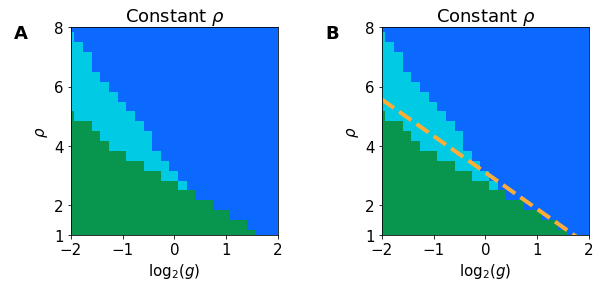

In [204]:
fit_curve = hv.Curve(
    (g_plot_, approx_bound)
).opts(
    c=cc.CET_L8[200],
    linewidth=4,
    linestyle="dashed",
)

constant_dens_plot + (constant_dens_plot * fit_curve) # + (constant_dens_plot2 * fit_curve)

## Plot phase diagram with `t_crit` level sets

In [205]:
param_space_3d = param_space_agg.copy()
param_space_3d[:, 0] = np.log2(param_space_3d[:, 0])
# param_space_3d[:, 2] = param_space_3d[:, 2] - param_space_3d[:, 1]
which_growing = param_space_3d[:, 2] >= param_space_3d[:, 1]

In [206]:
phase_clrs = np.array([*cc.glasbey_warm])[phase_behavior_new]

In [207]:
# t_crit = 5
# rho_max_ls = np.linspace(1, 8, 50)
# log10g_ls = np.linspace(-1, 0.75, 50)

# X, Y = np.meshgrid(log10g_ls, rho_max_ls)
# rho_crit_ls = rho_crit_approx(10**X)
# Z = t_crit_approx_levelset(t_crit, 10**X, Y)

# tol = 1e-5
# valid_samples = np.logical_and(Y - rho_crit_ls >= -tol, rho_crit_ls - Z >= -tol)

# xx, yy, zz = X[valid_samples], Y[valid_samples], Z[valid_samples]

In [208]:
t_crits = [1, 10]
n_samples = 50
tol = 1e-5

In [209]:
def plot_3d_phase_boundaries_log2(t_crits, n_samples, tol=1e-5, dpi=150, azim=300, elev=20):

    rho_max_ls = np.linspace(1, 8, n_samples)
    log2g_ls = np.linspace(-2, 2, n_samples)

    X, Y = np.meshgrid(log2g_ls, rho_max_ls)
    rho_crit_ls = rho_crit_approx(2 ** X)

    rho_crit_ls = t_crit_approx_levelset(0, 2 ** X, Y)
    valid_samples = Y - rho_crit_ls >= -tol
    xx, yy = X[valid_samples].flatten(), Y[valid_samples].flatten()

    fig = plt.figure(figsize=(4, 4))
    ax = plt.axes(projection="3d")
    ax.azim = azim
    ax.elev = elev

    # ax.contour3D(X, Y, Z, 50, cmap='binary')
    ax.set_xlabel(r"$log_{2}(g)$")
    ax.set_xticks([-2, -1, 0, 1, 2])
    ax.set_xticklabels([r"$-2$", r"$-1$", r"$0$", r"$1$", r"$2$"])
    ax.set_ylabel(r"$\rho_{max}$")
    ax.set_yticks([0, 2, 4, 6, 8])
    ax.set_ylim3d([0, 8])
    ax.set_zlabel(r"$\rho_0$")
    ax.set_zticks([0, 2, 4, 6, 8])
    ax.set_zlim3d([0, 8])
    ax.scatter(
        *param_space_3d[which_growing].T[np.array([0, 2, 1])],
        c=phase_clrs[which_growing],
        s=170,
        marker="s",
        alpha=0.005,
        linewidth=0,
    )
    ax.set_title(r"$t_{crit} =$ " + ", ".join([str(i) for i in t_crits]))

    for i, tc in enumerate(t_crits):

        zz = t_crit_approx_levelset(tc, 2 ** xx, yy)
        ax.plot_trisurf(
            xx.flatten(),
            yy.flatten(),
            zz.flatten(),
            facecolor=cc.glasbey_cool[i],
            alpha=0.5,
            edgecolor="none",
        )

    # ax.scatter(xx, yy, zz, c=cc.bmy[0], s=1, alpha=0.5)

#     plt.tight_layout()
    fig.set_facecolor("w")
    ax.set_facecolor("w")
    plt.gcf().set(dpi=dpi)

    return fig, ax

plots\20210415_sweep_TCphase_dense_log2g_3d_phase_tcrit_0_nsamples_50


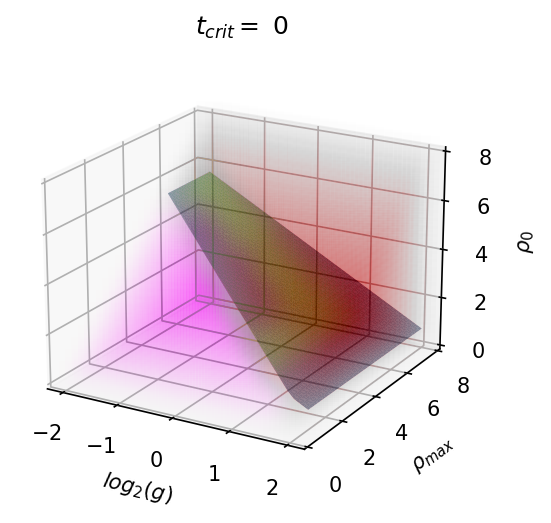

In [210]:
t_crits = [0]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_log2(t_crits, n_samples)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

plots\20210415_sweep_TCphase_dense_log2g_3d_phase_tcrit_1_nsamples_50


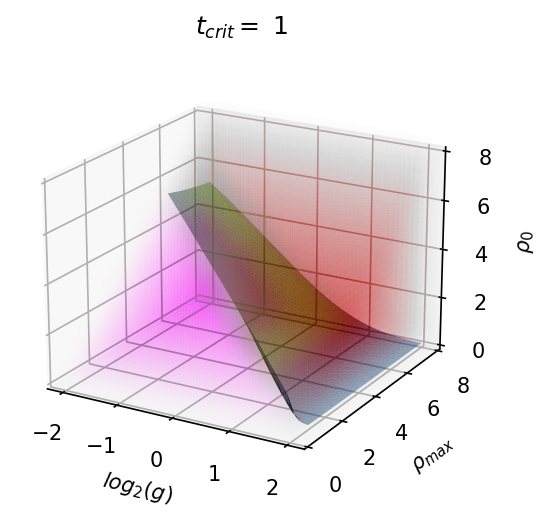

In [211]:
t_crits = [1]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_log2(t_crits, n_samples)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

plots\20210415_sweep_TCphase_dense_log2g_3d_phase_tcrit_10_nsamples_50


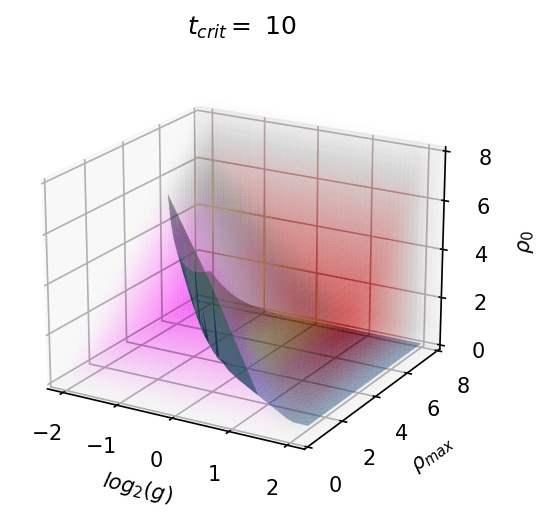

In [212]:
t_crits = [10]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_log2(t_crits, n_samples)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

plots\20210415_sweep_TCphase_dense_log2g_3d_phase_tcrit_1_10_nsamples_50


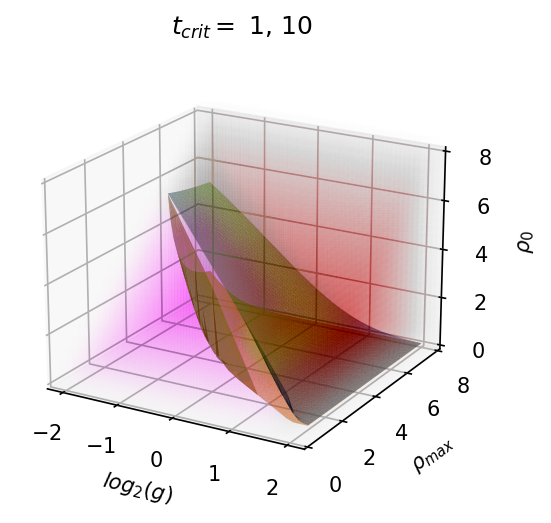

In [213]:
t_crits = [1, 10]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_log2(t_crits, n_samples)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

plots\20210415_sweep_TCphase_dense_log2g_3d_phase_tcrit_0_20_nsamples_50


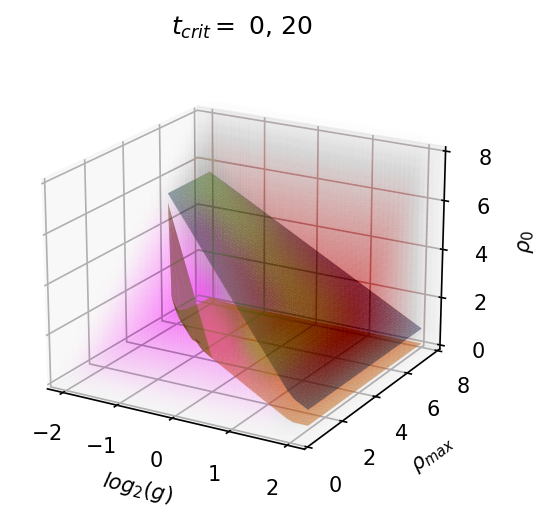

In [214]:
t_crits = [0, 20]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_log2(t_crits, n_samples)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

plots\20210415_sweep_TCphase_dense_log2g_3d_phase_tcrit_0_5_nsamples_50


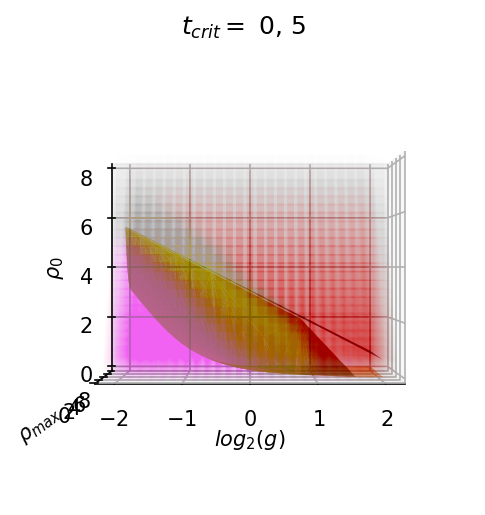

In [215]:
t_crits = [0, 5]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_log2(t_crits, n_samples, azim=270, elev=0)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

<hr>

# Linear sampled `g`

In [216]:
run_name = "20210415_sweep_TCphase_dense_ling"

In [217]:
data_regexp = os.path.join(data_dir, run_name, "*_results.npz")
data_path = [os.path.abspath(f) for f in glob(data_regexp)]

if len(data_path) == 0:
    print("Could not find data with regexp {}".format(os.path.abspath(data_regexp)))
elif len(data_path) > 1:
    print("More than one file matching regexp {}".format(os.path.abspath(data_regexp)))
    print("Matching files:")
    print(data_path)

In [218]:
# Read data
data_file = data_path[0]
npz = np.load(data_file)

# Unpack variables
n = npz["n"]
t = npz["t"]
random_seeds = npz["random_seeds"]
sender_idx_rep = npz["sender_idx_rep"]
param_names = npz["param_names"]
param_space = npz["param_space"]
# S_actnum_param_constant = npz["S_actnum_param_constant"]
# S_tcmean_param_constant = npz["S_tcmean_param_constant"]
S_actnum_param = npz["S_actnum_param"]
S_tcmean_param = npz["S_tcmean_param"]

# Get parmaeter sampling values
rep_space     = np.sort(np.unique(param_space[:, 0].astype(int)))
g_space       = np.sort(np.unique(param_space[:, 1]))
rho_0_space   = np.sort(np.unique(param_space[:, 2]))
rho_max_space = np.sort(np.unique(param_space[:, 3]))

# Get number of runs sampled
n_runs = param_space.shape[0]
n_reps = rep_space.size
n_sets = n_runs // n_reps

# Store run metadata in DataFrame object
S_prop_df = pd.DataFrame(param_space, columns=param_names)
S_prop_df = S_prop_df.reset_index()
S_prop_df.rep = S_prop_df.rep.astype(int)

# Group runs by replicate
S_prop_rep_grp = S_prop_df.groupby(list(param_names[1:]))["index"]
S_prop_rep_grp = list(S_prop_rep_grp)

# Get sample numbers of each replicate set
S_prop_rep_idx = np.empty((n_sets, n_reps), dtype=int)
for i in range(n_runs // n_reps):
    S_prop_rep_idx[i] = S_prop_rep_grp[i][1].values

# Get parameters in each replicate set, preserving order 
param_space_agg = param_space[S_prop_rep_idx[:, 0], 1:]

In [219]:
print("Unpacked variables:", *list(npz.keys()), sep="\n\t")
print()
print(
    "Number of runs:",
    "{0} ({1} sets of {2} replicates)".format(n_runs, n_sets, n_reps),
    sep="\n\t",
)
print()
print("Parameters scanned:")
print(*["\t" + pn for pn in param_names])

Unpacked variables:
	n
	t
	random_seeds
	sender_idx_rep
	param_names
	param_space
	S_actnum_param
	S_tcmean_param

Number of runs:
	72000 (14400 sets of 5 replicates)

Parameters scanned:
	rep 	g 	rho_0 	rho_max


In [220]:
# Number of activated cells (mean of n = n_reps)
S_actnum_mean = S_actnum_param[S_prop_rep_idx, :].mean(axis=1)

# Mean fluorescence (mean of n = n_reps)
S_tcmean_mean = S_tcmean_param[S_prop_rep_idx, :].mean(axis=1)

# % of cells activated
S_prop_param = S_actnum_param / n
S_prop_mean = S_actnum_mean / n

In [221]:
# Threshold for phase behavior
phase_thresh = 0.05   #  % activated cells

# n_runs = S_prop_param.shape[0]

# Calculate phase behavior
iterator = range(n_runs)
# iterator = tqdm(iterator)
S_prop_bool = np.zeros((n_runs,), dtype=bool)
S_biph_bool = np.zeros((n_runs,), dtype=bool)

for i in iterator:
    S_prop_bool[i] = is_propagated(S_prop_param[i], phase_thresh)
    S_biph_bool[i] = is_biphasic(S_prop_param[i], phase_thresh)
#     monotonicity = np.array([is_monotonic(s) for s in S_prop_param])

In [222]:
# Average phase behavior over replicates
S_prop_pct = S_prop_bool[S_prop_rep_idx].mean(axis=1)
S_biph_pct = S_biph_bool[S_prop_rep_idx].mean(axis=1)

# If any replicates show behavior, set True
S_prop_bool_agg = np.any(S_prop_bool[S_prop_rep_idx], axis=1)
S_biph_bool_agg = np.any(S_biph_bool[S_prop_rep_idx], axis=1)

# Convert to phase
#   0 = no propagation, 1 = propagation, 2 = biphasic
phase_behavior = (1 + S_biph_bool_agg) * S_prop_bool_agg

__Visualize distribution of mean TC fluorescence at end of sampling time__

In [223]:
p = bokeh_catplot.ecdf(S_tcmean_mean[:, -1])

bokeh.io.show(p)

In [224]:
# dS_dt_init_mean = (S_tcmean_mean[:, 1] - S_tcmean_mean[:, 0]) / (t[1] - t[0])

In [225]:
p = bokeh_catplot.ecdf(dS_dt_init_mean)

bokeh.io.show(p)

In [226]:
# dS_dt_init_mean[np.logical_and(end_behavior.astype(bool), which_growing)].min()

In [227]:
init_thresh = 0.05
init_behavior = (dS_dt_init_mean > init_thresh).astype(int)
end_behavior = (S_tcmean_mean[:, -1] > phase_thresh).astype(int)

In [228]:
param_space_agg[np.logical_and((init_behavior - end_behavior) < 0, which_growing)]

array([[1.58333333, 2.        , 2.        ],
       [1.66666667, 1.33333333, 1.33333333],
       [1.66666667, 1.33333333, 1.66666667],
       [1.66666667, 1.33333333, 2.        ],
       [1.66666667, 1.66666667, 1.66666667],
       [1.66666667, 1.66666667, 2.        ],
       [1.66666667, 2.        , 2.        ],
       [1.75      , 0.33333333, 0.33333333],
       [1.75      , 0.33333333, 0.66666667],
       [1.75      , 0.33333333, 1.        ],
       [1.75      , 0.33333333, 1.33333333],
       [1.75      , 0.33333333, 1.66666667],
       [1.75      , 0.33333333, 2.        ],
       [1.75      , 0.33333333, 2.33333333],
       [1.75      , 0.66666667, 0.66666667],
       [1.75      , 0.66666667, 1.        ],
       [1.75      , 0.66666667, 1.33333333],
       [1.75      , 0.66666667, 1.66666667],
       [1.75      , 0.66666667, 2.        ],
       [1.75      , 1.        , 1.        ],
       [1.75      , 1.        , 1.33333333],
       [1.75      , 1.        , 1.66666667],
       [1.

In [229]:
phase_behavior_new = end_behavior + 2 * (1 - end_behavior) * init_behavior

### Plot 2D phase boundary for constant density

:Points   [x,y]
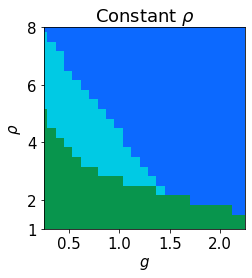

In [230]:
mask = param_space_agg[:, 1] == param_space_agg[:, 2]

constant_dens_plot = hv.Points(
    (param_space_agg[mask, 0], param_space_agg[mask, 2])
).opts(
    title = r"Constant $\rho$",
    xlim = (0.25, 2.25),
    ylim = ( 1, 8),
    xlabel = r"$g$",
    xticks = (0, 0.5, 1, 1.5, 2),
    ylabel = r"$\rho$",
    yticks = (1, 2, 4, 6, 8),
    marker = "s",
    s=100,
    c=np.array(cc.glasbey_cool)[phase_behavior_new[mask]], 
    cmap="plasma",
#     logx=True, 
    fontscale=1.5,
)

constant_dens_plot

In [231]:
g_plot_ = np.linspace(0.25, 2.25, 100)

approx_bound = rho_crit_approx(g_plot_)

:Layout
   .Points.I  :Points   [x,y]
   .Overlay.I :Overlay
      .Points.I :Points   [x,y]
      .Curve.I  :Curve   [x]   (y)
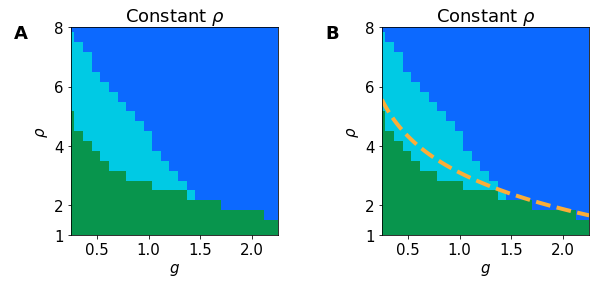

In [232]:
fit_curve = hv.Curve(
    (g_plot_, approx_bound)
).opts(
    c=cc.CET_L8[200],
    linewidth=4,
    linestyle="dashed",
)

constant_dens_plot + (constant_dens_plot * fit_curve) # + (constant_dens_plot2 * fit_curve)

## Plot phase diagram with `t_crit` level sets

In [233]:
param_space_3d = param_space_agg.copy()
# param_space_3d[:, 0] = np.log2(param_space_3d[:, 0])
# param_space_3d[:, 2] = param_space_3d[:, 2] - param_space_3d[:, 1]
which_growing = param_space_3d[:, 2] >= param_space_3d[:, 1]

In [234]:
phase_clrs = np.array([*cc.glasbey_warm])[phase_behavior_new]

In [235]:
# t_crit = 5
# rho_max_ls = np.linspace(1, 8, 50)
# log10g_ls = np.linspace(-1, 0.75, 50)

# X, Y = np.meshgrid(log10g_ls, rho_max_ls)
# rho_crit_ls = rho_crit_approx(10**X)
# Z = t_crit_approx_levelset(t_crit, 10**X, Y)

# tol = 1e-5
# valid_samples = np.logical_and(Y - rho_crit_ls >= -tol, rho_crit_ls - Z >= -tol)

# xx, yy, zz = X[valid_samples], Y[valid_samples], Z[valid_samples]

In [236]:
t_crits = [1, 10]
n_samples = 50
tol = 1e-5

In [237]:
def plot_3d_phase_boundaries_lin(t_crits, n_samples, tol=1e-5, dpi=150, azim=300, elev=20):

    rho_max_ls = np.linspace(1, 8, n_samples)
    ling_ls = np.linspace(0.25, 2.25, n_samples)

    X, Y = np.meshgrid(ling_ls, rho_max_ls)
    rho_crit_ls = rho_crit_approx(X)

    rho_crit_ls = t_crit_approx_levelset(0, X, Y)
    valid_samples = Y - rho_crit_ls >= -tol
    xx, yy = X[valid_samples].flatten(), Y[valid_samples].flatten()

    fig = plt.figure(figsize=(4, 4))
    ax = plt.axes(projection="3d")
    ax.azim = azim
    ax.elev = elev

    # ax.contour3D(X, Y, Z, 50, cmap='binary')
    ax.set_xlabel(r"$g$")
    ax.set_xticks([0.5, 1, 1.5, 2])
    ax.set_xticklabels([r"$0.5$", r"$1$", r"$1.5$", r"$2$"])
    ax.set_ylabel(r"$\rho_{max}$")
    ax.set_yticks([0, 2, 4, 6, 8])
    ax.set_ylim3d([0, 8])
    ax.set_zlabel(r"$\rho_0$")
    ax.set_zticks([0, 2, 4, 6, 8])
    ax.set_zlim3d([0, 8])
    ax.scatter(
        *param_space_3d[which_growing].T[np.array([0, 2, 1])],
        c=phase_clrs[which_growing],
        s=170,
        marker="s",
        alpha=0.005,
        linewidth=0,
    )
    ax.set_title(r"$t_{crit} =$ " + ", ".join([str(i) for i in t_crits]))

    for i, tc in enumerate(t_crits):

        zz = t_crit_approx_levelset(tc, xx, yy)
        ax.plot_trisurf(
            xx.flatten(),
            yy.flatten(),
            zz.flatten(),
            facecolor=cc.glasbey_cool[i],
            alpha=0.5,
            edgecolor="none",
        )

    # ax.scatter(xx, yy, zz, c=cc.bmy[0], s=1, alpha=0.5)

#     plt.tight_layout()
    fig.set_facecolor("w")
    ax.set_facecolor("w")
    plt.gcf().set(dpi=dpi)

    return fig, ax

plots\20210415_sweep_TCphase_dense_ling_3d_phase_tcrit_0_nsamples_50


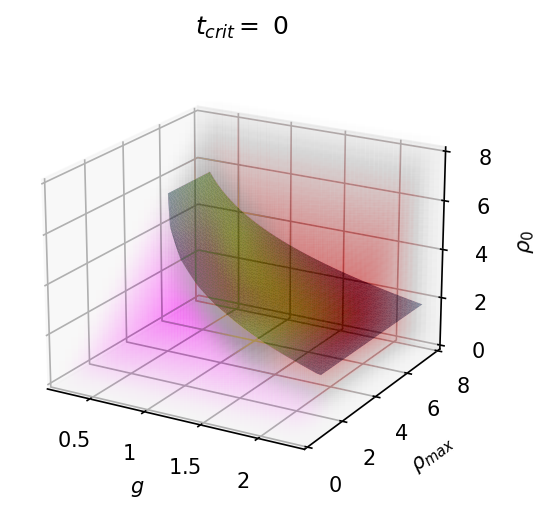

In [238]:
t_crits = [0]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_lin(t_crits, n_samples)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

plots\20210415_sweep_TCphase_dense_ling_3d_phase_tcrit_1_nsamples_50


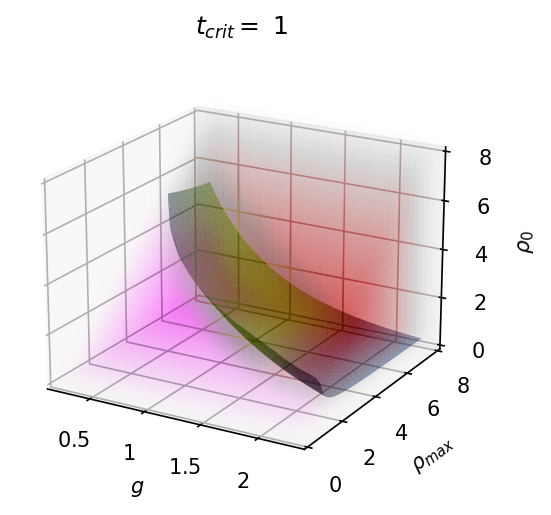

In [239]:
t_crits = [1]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_lin(t_crits, n_samples)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

plots\20210415_sweep_TCphase_dense_ling_3d_phase_tcrit_10_nsamples_50


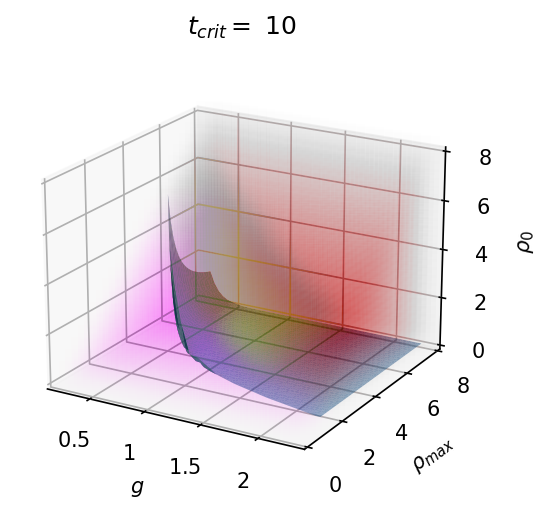

In [240]:
t_crits = [10]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_lin(t_crits, n_samples)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

plots\20210415_sweep_TCphase_dense_ling_3d_phase_tcrit_1_10_nsamples_50


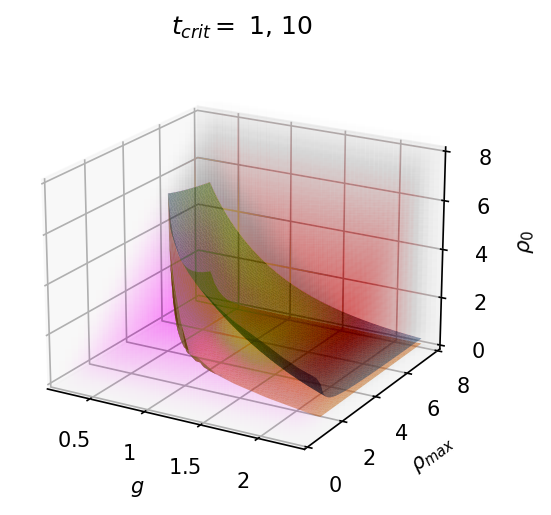

In [241]:
t_crits = [1, 10]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_lin(t_crits, n_samples)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

plots\20210415_sweep_TCphase_dense_ling_3d_phase_tcrit_0_20_nsamples_50


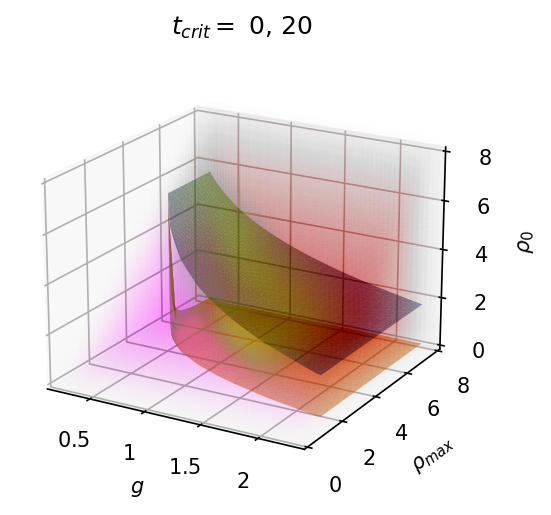

In [242]:
t_crits = [0, 20]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_lin(t_crits, n_samples)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

plots\20210415_sweep_TCphase_dense_ling_3d_phase_tcrit_0_5_nsamples_50


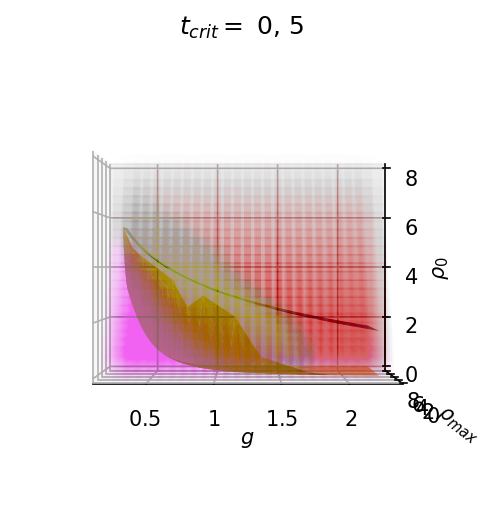

In [243]:
t_crits = [0, 5]
n_samples = 50

fig, ax = plot_3d_phase_boundaries_lin(t_crits, n_samples, azim=270, elev=0)

fig_fname = run_name + "_3d_phase_tcrit_{0}_nsamples_{1}".format(
    "_".join([str(i) for i in t_crits]), n_samples
)
fig_path = os.path.join("plots", fig_fname)

print(fig_path)
plt.savefig(fig_path, dpi=150)
# plt.show()

<hr>

## Plot 2d phase diagram for fixed `g`

In [248]:
g_idx = [3, 9, 15]

plots = []
for gi in g_idx:
    
    g_ = g_space[gi]
    mask = np.logical_and(param_space_agg[:, 0] == g_, which_growing)

    plot = hv.Points(
        (param_space_agg[mask, 1], param_space_agg[mask, 2])
    ).opts(
        title = r"$g = {0:.2f}$".format(g_),
        xlim = ( 1, 8),
        ylim = ( 1, 8),
        xlabel = r"$\rho_{0}$",
        xticks = (1, 2, 4, 6, 8),
        ylabel = r"$\rho_{max}$",
        yticks = (1, 2, 4, 6, 8),
    #     marker = "s",
        s=75,
        c=np.array(cc.glasbey_cool)[phase_behavior_new[mask]], 
        cmap="plasma",
    #     logx=True, 
        fontscale=1.5,
    )

    plots.append(plot)

:Layout
   .Points.I   :Points   [x,y]
   .Points.II  :Points   [x,y]
   .Points.III :Points   [x,y]
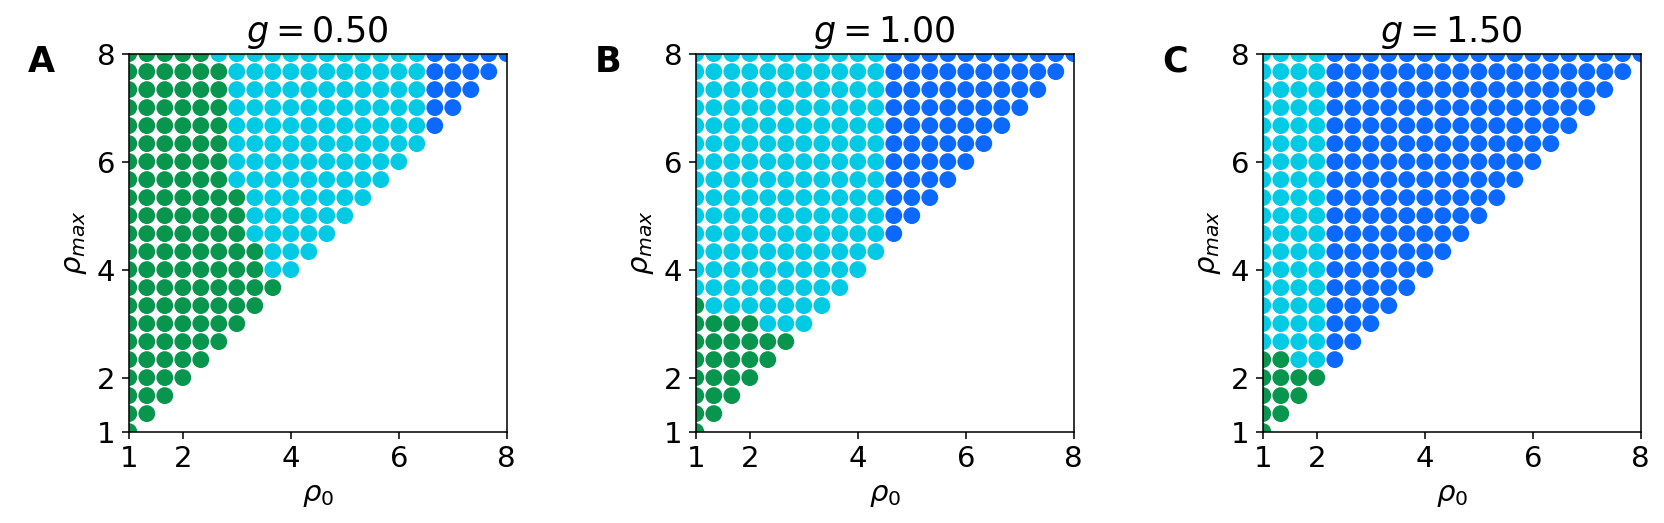

In [249]:
hv.output(hv.Layout(plots), dpi=140)

In [142]:
t_crit = t_crit_approx(g_, param_space_agg[mask, 1], param_space_agg[mask, 2])
t_crit[np.isnan(t_crit)] = np.inf
t_crit[t_crit < 0] == 0
t_crit[t_crit > 5] == 5


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [147]:
g_idx = [3, 9, 15]

plots = []
for gi in g_idx:
    
    g_ = g_space[gi]
    mask = np.logical_and(param_space_agg[:, 0] == g_, which_growing)
    
    t_crit = t_crit_approx(g_, param_space_agg[mask, 1], param_space_agg[mask, 2])
    t_crit[np.isnan(t_crit)] = np.inf
    t_crit[t_crit < 0] = 0
    t_crit[t_crit > 5] = 5
    
    plot = hv.Points(
        (param_space_agg[mask, 1], param_space_agg[mask, 2])
    ).opts(
        title = r"$g = {0:.2f}$".format(g_),
        xlim = ( 1, 8),
        ylim = ( 1, 8),
        xlabel = r"$\rho_{0}$",
        xticks = (1, 2, 4, 6, 8),
        ylabel = r"$\rho_{max}$",
        yticks = (1, 2, 4, 6, 8),
    #     marker = "s",
        s=75,
        c=t_crit, 
        cmap="cet_bgy",
        colorbar = True,
#         clim=(0, 5),
    #     logx=True, 
        fontscale=1.5,
#     ).redim.range(
#         c=(0, 5)
    )
    
#     plot = plot.options(clipping_colors = {'min': 'green', 'max': 'red', 'NaN': 'gray'})
    
    plots.append(plot)

:Layout
   .Points.I   :Points   [x,y]
   .Points.II  :Points   [x,y]
   .Points.III :Points   [x,y]
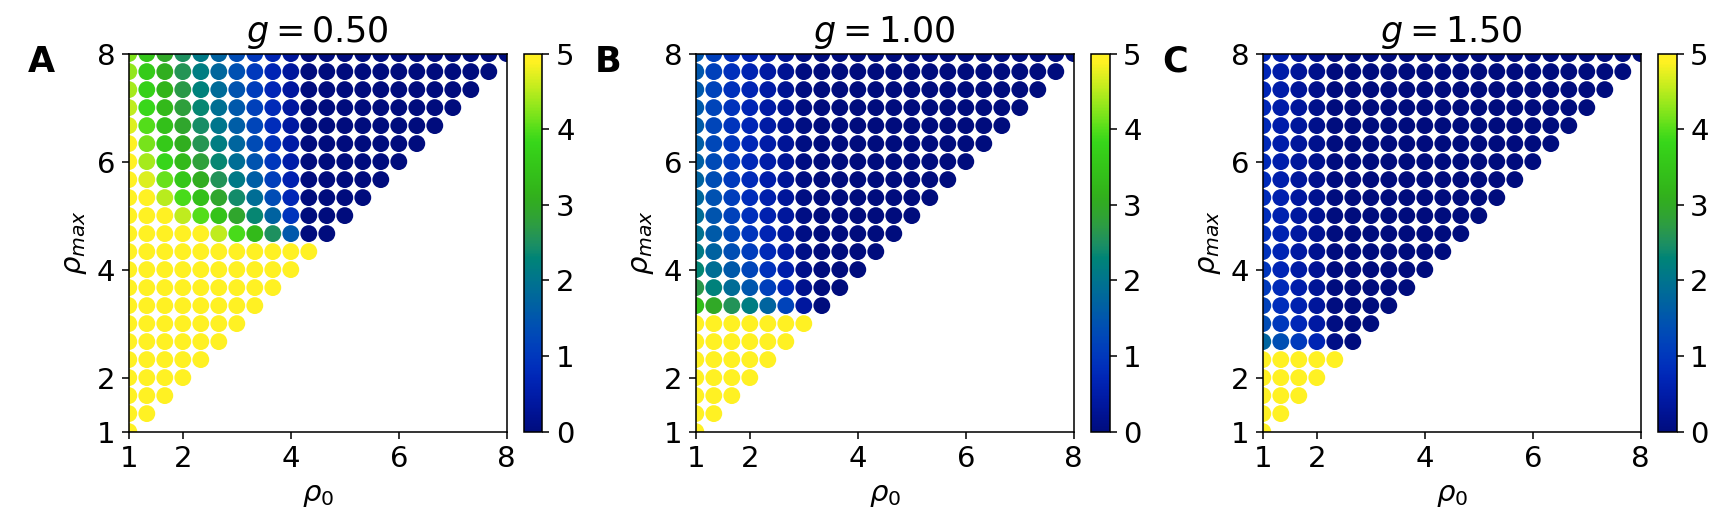

In [148]:
hv.output(hv.Layout(plots), dpi=140)

In [ ]:
t_crit_approx()

<hr>

# Testing 3D scatter-plots

In [ ]:
# hv.Scatter3D(
#     param_space_3d[which_growing][:, np.array([0, 2, 1])]
# ).opts(
#     c=phase_behavior[which_growing],
#     linewidth=0,
#     s=200,
#     alpha=0.02,
# #     marker="s",
# )

<hr>

In [ ]:
# def crit_g_curve(rho_0, rho_range):
    
#     return hv.Curve(
#         (np.array([crit_g_approx(rho_0)] * rho_range.size), rho_range, )
#     ).opts(
#         c=cc.CET_L8[100],
#         linewidth=4,
#         linestyle="dashed",
#     )

In [ ]:
# rho_range = np.linspace(1, 8, 100)

# nplots = rho_0_space.size
# phase_fit_plots = []
# for i in range(nplots):
#     mask = param_space_agg[:, 1] == rho_0_space[i]
#     plot = hv.Points(
#         (param_space_agg[mask, 0], param_space_agg[mask, 2])
#     ).opts(
#         title = r"$\rho_0$ = " + f"{rho_0_space[i]:.2f}",
#         xlim = (0.1, 10),
#         ylim = (  1,  8),
#         xlabel = r"$g$",
#         ylabel = r"$\rho_{max}$",
#         yticks = (1, 2, 4, 6, 8),
#         marker = "s",
#         s=100,
#         c=np.array(cc.glasbey_cool)[phase_behavior[mask]], 
#         cmap="plasma",
#         logx=True, 
#         aspect=2.5,
#         fontscale=1.5,
#     )    
    
#     phase_fit_plots.append(plot * crit_g_curve(rho_0_space[i], rho_range) * fit_curve)


In [ ]:
# hv.Layout(phase_fit_plots[2:13:3]).cols(2).opts(title=f"Phase behavior")

In [ ]:
# nplots = rho_0_space.size
# prop_plots = []
# for i in range(nplots):
#     mask = param_space_agg[:, 1] == rho_0_space[i]
#     plot = hv.Points(
#         (param_space_agg[mask, 0], param_space_agg[mask, 2])
#     ).opts(
#         title = r"$\rho_0$ = " + f"{rho_0_space[i]:.2f}",
#         xlim = (0.1, 10),
#         ylim = (  1,  8),
#         xlabel = r"$g$",
#         ylabel = r"$\rho_{max}$",
#         yticks = (1, 2, 4, 6, 8),
#         marker = "s",
#         s=70,
#         c=S_prop_pct[mask], 
#         cmap="cet_isoluminant_cgo_80_c38",
#         logx=True, 
#         aspect=2.5,
#         fontscale=1.5,
#     )
    
#     prop_plots.append(plot)
    

In [ ]:
# hv.Layout(prop_plots[2::6]).cols(4).opts(title=f"Propagation index (% replicates propagated)")

In [ ]:
# nplots = rho_0_space.size
# phase_plots = []
# for i in range(nplots):
#     mask = param_space_agg[:, 1] == rho_0_space[i]
#     plot = hv.Points(
#         (param_space_agg[mask, 0], param_space_agg[mask, 2])
#     ).opts(
#         title = r"$\rho_0$ = " + f"{rho_0_space[i]:.2f}",
#         xlim = (0.1, 10),
#         ylim = (  1,  8),
#         xlabel = r"$g$",
#         ylabel = r"$\rho_{max}$",
#         yticks = (1, 2, 4, 6, 8),
#         marker = "s",
#         s=70,
#         c=np.array(cc.glasbey_cool)[phase_behavior[mask]], 
#         cmap="plasma",
#         logx=True, 
#         aspect=2.5,
#         fontscale=1.5,
#     )
    
#     phase_plots.append(plot)
    

In [ ]:
# hv.Layout(phase_plots[2::3]).cols(4).opts(title=f"Phase behavior")